# Notebook - short
functions in one place to use it efficiently

In [1]:
# required libraries
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import math
import scipy
import itertools
import pandas as pd 
from timeit import default_timer as timer

In [2]:
#
# Fundamental values of the grid
#
def t_calc(
        a,
        m_eff,
        m_0,
        hbar,
        _1eV
):
    return (hbar*hbar) / (2*m_eff*m_0*a*a*1e-20*_1eV) # [eV]

def a_calc(
        site_size,
        site_elements
):
    return site_size / (site_elements - 1) # [Angstrom] - distance between elements 

#
# Dispersion 2D
#
def dispersion_2D(
    site_elements,
    t,
    a,
    hbar,
    m_eff, 
    m_0,
    _1eV,
    E0,
    dEs):
    pi = np.pi
    kx = np.linspace(-pi/a,pi/a,site_elements)
    ky = np.linspace(-pi/a,pi/a,site_elements)
    kxx, kyy = np.meshgrid(kx, ky)
    dEs = 0

    # kp
    #f = lambda kx, ky: (hbar ** 2) * (kx ** 2 + ky ** 2) / (2 * m_eff * m_0 * _1eV * 10e-20) + E0
    f = lambda kx, ky: ((hbar) ** 2) * ((kx*1e10) ** 2 + (ky*1e10) ** 2) / (2 * m_eff * m_0 ) /_1eV + E0
    ek_kp = np.array(list(map(f, kxx, kyy)))


    # cos
    ek_cos = dEs - 2 * t * (np.cos(kxx * a) + np.cos(kyy * a))

    # scale the ek_cos so it will start at 0
    f = lambda x: x - delta
    delta = np.amin(ek_cos)
    ek_cos = np.array(list(map(f, ek_cos)))

    # plot dispersion
    plt.plot(kx,ek_cos[0],'o', mfc = 'none', mec = 'blue', color="blue", label="cos()")
    for i in range(1,site_elements):
        plt.plot(kx,ek_cos[i],'o', mfc = 'none', mec = 'blue', color="blue")
    plt.plot(kx,ek_kp[0],'.', color="red", label="kp")
    for i in range(1,site_elements):    
        plt.plot(kx,ek_kp[i],'.', color="red")
    plt.xlabel("k (1/A)")
    plt.ylabel("E (eV)")
    plt.hlines(8*t, -pi/a, pi/a, colors="black", linestyles="--")
    plt.hlines(0, -pi/a, pi/a, colors="black", linestyles="--")
    plt.vlines(-pi/a, 0, np.amax(ek_kp), colors="black", linestyles="--")
    plt.vlines(pi/a, 0, np.amax(ek_kp), colors="black", linestyles="--")
    plt.legend()
    plt.title("Dispersion 2D")
    plt.show()


#
# Layout
#
def initialize_layout(site_elements, a):
    Layout = {"2Dneighbours": np.zeros((site_elements, site_elements), dtype=int),
              "realLocation": [[[]]]}
    k = 1
    for i in range(site_elements):
        for j in range(site_elements):
            Layout["2Dneighbours"][j][i] = k
            Layout["realLocation"].append([k,[a*i,a*j]])
            k += 1
    Layout["realLocation"] = Layout["realLocation"][1:]

    return Layout

def plot_layout(Layout):
    X = np.zeros(len(Layout["realLocation"]))
    Y = np.zeros(len(Layout["realLocation"]))
    for i in range(len(Layout["realLocation"])):
        elem = Layout["realLocation"][i]
        X[i] = elem[1][0]
        Y[i] = elem[1][1]
    plt.scatter(X, Y, c='blue', linewidths=1)
    plt.gca().set_aspect('equal', 'box')
    plt.title("grid")
    plt.show()   



#
# Hamiltonian
#
def initialize_hamiltonian(Layout, t, PBC:bool, V_max, r_0):
    site_elements = Layout["2Dneighbours"].shape[0]
    elements = site_elements**2
    Hamiltonian = np.zeros((elements,elements))
    
    for i in range(site_elements):
        for j in range(site_elements):
            elem = Layout["2Dneighbours"][i,j] - 1

            next_x, prev_x, next_y, prev_y = neighbours(Layout["2Dneighbours"], i, j, PBC)

            if next_x in range(elements):
                Hamiltonian[next_x,elem] = -t
                Hamiltonian[elem,next_x] = -t

            if prev_x in range(elements):    
                Hamiltonian[prev_x,elem] = -t
                Hamiltonian[elem,prev_x] = -t

            if next_y in range(elements):
                Hamiltonian[next_y,elem] = -t
                Hamiltonian[elem,next_y] = -t
            
            if prev_y in range(elements):
                Hamiltonian[prev_y,elem] = -t
                Hamiltonian[elem,prev_y] = -t

    for i in range(elements):

       Hamiltonian[i][i] = 4*t + V(i+1, Layout, V_max, r_0)
       
    return Hamiltonian

def neighbours(Layout, i, j, PBC:bool):
    site_elements = Layout.shape[0]
    if PBC:
        #print("PBC True")
        if j in range(1,site_elements-1):
            next_y = j + 1
            prev_y = j - 1
        elif j == 0:
            next_y = j + 1
            prev_y = site_elements-1
        else:
            next_y = 0
            prev_y = j - 1

        if i in range(1,site_elements-1):
            next_x = i + 1
            prev_x = i - 1
        elif i == 0:
            next_x = i + 1
            prev_x = site_elements-1
        else:
            next_x = 0
            prev_x = i - 1
        
        return Layout[next_x,j]-1, Layout[prev_x,j]-1, Layout[i,next_y]-1, Layout[i,prev_y]-1 
    else:
        next_y = j + 1
        prev_y = j - 1
        next_x = i + 1
        prev_x = i - 1

        if prev_y in range(0,site_elements):
            prev_y_elem = Layout[i,prev_y]-1 
        else:
            prev_y_elem = -1
        if next_y in range(0,site_elements):
            next_y_elem = Layout[i,next_y]-1
        else:
            next_y_elem = -1
        if prev_x in range(0,site_elements):
            prev_x_elem =  Layout[prev_x,j]-1
        else:
            prev_x_elem = -1
        if next_x in range(0,site_elements):
            next_x_elem =  Layout[next_x,j]-1
        else:
            next_x_elem = -1

        return next_x_elem, prev_x_elem, next_y_elem, prev_y_elem 

def diagonalize_hamiltonian(Hamiltonian):
    #E,psiT = np.linalg.eigh(Hamiltonian) # This computes the eigen values and eigenvectors
    #psi = np.transpose(psiT)   # We take the transpose of psiT to the wavefunction vectors can accessed as psi[n]
    #plt.plot(E, 'o')
    #plt.show()
    return np.linalg.eigvalsh(Hamiltonian)

def diagonalize_hamiltonian_with_psi(Hamiltonian):
    E,psiT = np.linalg.eigh(Hamiltonian) # This computes the eigen values and eigenvectors
    psi = np.transpose(psiT)   # We take the transpose of psiT to the wavefunction vectors can accessed as psi[n]
    #E, psi = scipy.linalg.eigh(Hamiltonian)
    #plt.plot(E, 'o')
    #plt.show()
    return E, psi

def show_hamiltonian(Hamiltonian):
    Hamiltonian = np.flip(Hamiltonian,axis=1)
    ran = math.floor(math.sqrt(Hamiltonian.size))
    fig, ax = plt.subplots()
    pcm = ax.imshow(Hamiltonian, cmap='hot', extent=[0, ran, 0, ran])
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax.invert_yaxis()
    ax.xaxis.set_label_position('top')
    fig.colorbar(pcm, ax=ax)
    plt.show()

def plot_eigenvalues_hamiltonian_whole(diagonalizated_hamiltonain, t):
    plt.plot(diagonalizated_hamiltonain, '.')
    # bottom = np.amin(diagonalizated_hamiltonain)
    plt.hlines(8*t, 0, len(diagonalizated_hamiltonain), colors="red", linestyles="--")
    plt.hlines(0, 0, len(diagonalizated_hamiltonain), colors="red", linestyles="--")
    plt.xlabel("eigenvalue index")
    plt.ylabel("E (eV)")
    plt.title("Eigenvalues of Hamiltonian")
    plt.show()

def plot_eigenvalues_hamiltonian(diagonalizated_hamiltonain):
    plt.plot(diagonalizated_hamiltonain, 'o')
    plt.xlabel("eigenvalue index")
    plt.ylabel("E (eV)")
    plt.title("Eigenvalues of Hamiltonian")
    plt.show()

def plot_multiple_eigenvalues_hamiltonian(diagonalizated_hamiltonain_list, label_list, plot_first):
    if len(label_list) < len(diagonalizated_hamiltonain_list):
        label_list = ["Analitical"] + label_list
    i=0
    for diagH in diagonalizated_hamiltonain_list:
        plt.plot(diagH[:plot_first], 'o', label=str(label_list[i]))
        i+=1
    plt.xlabel("eigenvalue index")
    plt.ylabel("E (eV)")
    plt.legend()
    plt.title("Comparison of different results.")
    plt.show()

def eigenvalues_hamiltonian(
        site_size,
        site_elements,
        PBC:bool,
        V_max, 
        r_0,
        m_eff,
        m_0,
        hbar,
        _1eV
):
    a = a_calc(site_size=site_size, site_elements=site_elements)
    t = t_calc(a=a, m_eff=m_eff, m_0=m_0, hbar=hbar, _1eV=_1eV)
    Layout = initialize_layout(site_elements, a)
    Hamiltonian = initialize_hamiltonian(Layout, t, PBC, V_max, r_0)
    return diagonalize_hamiltonian(Hamiltonian)

def comparison_eigenvalues(
        site_size,
        elements_list:list,
        PBC:bool,
        V_max, 
        r_0,
        m_eff,
        m_0,
        hbar,
        _1eV
):
    omega = omega_calc(V_max, r_0, m_eff, m_0,  _1eV)
    ham_list = [analitical_energies(11, omega, V_max, hbar, _1eV)]
    idx = 0 
    for i in elements_list:
        ham_list.append(eigenvalues_hamiltonian(
                site_size=site_size,
                site_elements=i,
                PBC=PBC,
                V_max=V_max, 
                r_0=r_0,
                m_eff=m_eff,
                m_0=m_0,
                hbar=hbar,
                _1eV=_1eV
        ))
        idx+=1
    return ham_list

#
# Potential
#
def V(i, Layout, V_max, r_0):
    dist_sqr = distance_sqr_from_center(i, Layout)
    return V_n_direct(dist_sqr, V_max, r_0)

def V_n_direct(dist_sqr, V_max, r_0):
    dist_sqr = abs(dist_sqr)
    if np.sqrt(dist_sqr) >= r_0:
        return 0
    else:
        return V_max/(r_0*r_0) * dist_sqr - V_max

def distance_sqr_from_center(elem1, Layout):
    site_size = Layout["realLocation"][len(Layout["realLocation"])-1][1][0]
    center = site_size/2
    #for p_elem in Layout["realLocation"]:
    #    if elem1 == p_elem[0]:
    #        x1, y1 = p_elem[1][0], p_elem[1][1]
    x1, y1 = Layout["realLocation"][elem1-1][1][0], Layout["realLocation"][elem1-1][1][1]
    return (x1 - center)**2 + (y1 - center)**2

def plot_potential_on_grid(Layout_base, site_size, site_elements, V_max, r_0):
    a = a_calc(site_size, site_elements)
    Layout = initialize_layout(site_elements, a)

    Potencial = np.zeros_like(Layout["2Dneighbours"], dtype=float)
    for i in range(site_elements):
        for j in range(site_elements):
            Potencial[j,i] = V((i*site_elements+j+1), Layout, V_max, r_0)

    X = np.zeros(len(Layout_base["realLocation"]))
    Y = np.zeros(len(Layout_base["realLocation"]))
    for i in range(len(Layout_base["realLocation"])):
        elem = Layout_base["realLocation"][i]
        X[i] = elem[1][0]
        Y[i] = elem[1][1]

    plt.scatter(X, Y, c='blue', linewidths=1)
    plt.gca().set_aspect('equal', 'box')
    plt.imshow(Potencial, cmap=cm.plasma, extent = [0, site_size, 0, site_size])
    plt.colorbar()
    plt.xlabel("x [A]")
    plt.ylabel("y [A]")
    plt.title("Better use plot_potential_on_grid_heat() function")
    plt.show()

def plot_potential_on_grid_heat(Layout_base, site_size, site_elements, V_max, r_0):
    a = a_calc(site_size, site_elements)
    Layout = initialize_layout(site_elements, a)
    center = site_size/2
    circle = plt.Circle((center, center), r_0, color='black', fill=False)

    Potencial = np.zeros_like(Layout["2Dneighbours"], dtype=float)
    for i in range(site_elements):
        for j in range(site_elements):
            Potencial[j,i] = V((i*site_elements+j+1), Layout, V_max, r_0)

    X = np.zeros(len(Layout_base["realLocation"]))
    Y = np.zeros(len(Layout_base["realLocation"]))
    for i in range(len(Layout_base["realLocation"])):
        elem = Layout_base["realLocation"][i]
        X[i] = elem[1][0]
        Y[i] = elem[1][1]

    plt.scatter(X, Y, c=Potencial, linewidths=1)
    plt.gca().set_aspect('equal', 'box')
    #plt.plot(center, center, "o", color="black")
    plt.gca().add_patch(circle)
    plt.colorbar()
    plt.xlabel("x [A]")
    plt.ylabel("y [A]")
    title = """Potencial V={V_max}eV on the grid"""
    plt.title(title.format(V_max=V_max))
    plt.show()

#
# Analitical energies
#
def omega_calc(V, r, m_eff, m_0, _1eV): # in [J]
    return np.sqrt((2*V*_1eV)/(m_eff*m_0*(r*1e-10)**2)) # 

def analitical_state(n_1, n_2, omega, V, hbar, _1eV):
    state_Jule = hbar * omega  * (n_1 + n_2 + 1) - V * _1eV
    state_eV = hbar * omega  * (n_1 + n_2 + 1) / _1eV - V
    state_eV_2 = state_Jule / _1eV
    # print(state_Jule, state_eV, state_eV_2)
    # hbar = np.pi * hbar / _1eV
    return state_eV # hbar * omega  * (n_1 + n_2 + 1) - V

def analitical_energies(N, omega, V, hbar, _1eV):
    n_x = N #math.floor(math.sqrt(N))
    #fill_more = N - n_x**2
    n = np.arange(0, n_x, 1)
    
    x = list(itertools.product(n, n))
    Energies = np.zeros(len(x))
    i = 0
    for elem in x:
        Energies[i] = analitical_state(elem[0], elem[1], omega, V, hbar, _1eV)
        i+=1
    return np.sort(Energies)

#
# Wave function psi
#
def psi_in_dot(psi, i, Layout_base, site_elements, r_0):    # calculate percentage of wave function in a quantum dot (in potential range r_0)
    psi_test = np.reshape(psi[i], (-1, site_elements)).flatten()

    psi_inside = 0
    psi_outside = 0

    for i in range(len(Layout_base["realLocation"])):
        elem = Layout_base["realLocation"][i]
        dist_sqr = distance_sqr_from_center(elem[0], Layout_base)
        if np.sqrt(dist_sqr) < r_0:
            psi_inside += abs(psi_test[i])
        else:
            psi_outside += abs(psi_test[i])

    return 100*psi_inside/(psi_inside+psi_outside)

def plot_psi_percentage_range(psi, n, Layout_base, site_elements, r_0):    # for n first wave fuction plot percentage of wave function in a quantum dot
    Y = np.zeros(n)
    for i in range(n):
        Y[i] = psi_in_dot(psi, i, Layout_base, site_elements, r_0)
    plt.plot(Y)
    plt.xlabel("psi id")
    plt.ylabel("perfent of psi in QD")
    title = """percentage of wave funtion in QD for first {n}"""
    plt.title(title.format(n=n))
    plt.show()

def plot_psi_on_grid(psi, i, Layout_base, site_size, site_elements, r_0):   # plot i-th wave function on the grid 
    center = site_size/2
    psi_test = np.reshape(psi[i], (-1, site_elements))
    circle = plt.Circle((center, center), r_0, color='black', fill=False)
    percentage = psi_in_dot(psi, i, Layout_base, site_elements, r_0)

    X = np.zeros(len(Layout_base["realLocation"]))
    Y = np.zeros(len(Layout_base["realLocation"]))
    for k in range(len(Layout_base["realLocation"])):
        elem = Layout_base["realLocation"][k]
        X[k] = elem[1][0]
        Y[k] = elem[1][1]

    plt.scatter(X, Y, c=psi_test.flatten(), linewidths=1)
    plt.gca().set_aspect('equal', 'box')
    plt.gca().add_patch(circle)
    plt.colorbar()
    plt.xlabel("x [A]")
    plt.ylabel("y [A]")
    title = """psi {i} # {percentage:.5f}% in QD"""
    plt.title(title.format(i=i, percentage=percentage))
    plt.show()

def psi_in_dot_1D(psi, i, site_size, site_elements, r_0):
    center = site_size/2
    x = np.linspace(0, site_size, site_elements)
    psi_test = np.reshape(psi[i], (-1, site_elements))[int(site_elements/2)]
    plt.plot(x, psi_test)
    plt.xlabel("x [A]")
    plt.ylabel("y [A]")
    plt.vlines(center-r_0, np.amin(psi_test), np.amax(psi_test), colors="black", linestyles="--")
    plt.vlines(center+r_0, np.amin(psi_test), np.amax(psi_test), colors="black", linestyles="--")
    title = """psi {i} profile through the center"""
    plt.title(title.format(i=i))
    plt.show()

def psi_n_3D(psi, n, site_size, site_elements):
    x = np.linspace(0,site_size,site_elements)
    xx, yy = np.meshgrid(x, x)

    #R = ((a*xx)**2 + (a*yy)**2)

    #f = lambda R, V_max, r_0: V_n(R, V_max, r_0)
    #Potencial = np.array(list(map(f, R, np.full(len(R), V_max), np.full(len(R), r_0))))
    psi_test = np.reshape(psi[n], (-1, site_elements))
    # show all Potencial
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(xx, yy, psi_test, cmap=cm.coolwarm,
                        linewidth=0, antialiased=False)
    title = """psi {i}"""
    plt.title(title.format(i=n))
    plt.show()
    

In [3]:
# definitions of fundamental constant used in calculations
site_size = 3000
site_elements = 130
PBC = False
V_max = 1 
r_0 = 1000
m_eff = 0.067
m_0 = scipy.constants.physical_constants["atomic unit of mass"][0]
hbar = scipy.constants.hbar
_1eV = scipy.constants.physical_constants["electron volt"][0]
a = a_calc(site_size, site_elements)
t = t_calc(a, m_eff, m_0, hbar, _1eV)
print(a,t)

23.25581395348837 0.10514413332493042


In [ ]:
# base calculations
Layout = initialize_layout(site_elements, a)
H = initialize_hamiltonian(Layout, t, PBC, V_max, r_0)
#print(H[3])
#show_hamiltonian(H)
df = pd.DataFrame(H)
title =   "_" + str(site_elements) + "_" + str(site_size) + "_" + str(r_0) + "_" +  str(V_max) + "_" + str(PBC) + "_" + str(m_eff) + ".csv"
print(title)
df.to_csv("Hamiltonian" + title, header=False, index=False)



In [ ]:
diagH, psi = diagonalize_hamiltonian_with_psi(H)

In [ ]:
df = pd.DataFrame(diagH)
df.to_csv("eigenvalues" + title, header=False, index=False)

In [ ]:
df = pd.DataFrame(psi)
df.to_csv("psi" + title, header=False, index=False)

In [ ]:
eigenvalues = pd.read_csv("eigenvalues" + title, header=None).transpose().to_numpy()[0]

In [ ]:
readH = pd.read_csv("Hamiltonian" + title, header=None, float_precision='round_trip').to_numpy()#.transpose().to_numpy()[0]
print((readH == H).all())
print("#########################")
print(H[0,0])

In [ ]:
print(readH)

In [ ]:
plot_eigenvalues_hamiltonian_whole(eigenvalues, t)
plot_eigenvalues_hamiltonian(eigenvalues[:40])

In [ ]:
# base calculations
Layout = initialize_layout(site_elements, a)
H = initialize_hamiltonian(Layout, t, PBC, V_max, r_0)
df = pd.DataFrame(H)
df.to_csv("Hamiltonian_130x130.csv", header=False, index=False)
#diagH, psi = diagonalize_hamiltonian_with_psi(H)
diagH_130 = diagonalize_hamiltonian(H)



In [ ]:
diagH_100x100_Julia = pd.read_csv("solved_100x100.csv", header=None).transpose().to_numpy()[0]
#print(diagH_100x100_Julia)
diagH_130x130_Julia = pd.read_csv("solved_130x130.csv", header=None).transpose().to_numpy()[0]

In [ ]:
omega = omega_calc(V_max, r_0, m_eff, m_0,  _1eV)
analitical_H = analitical_energies(11, omega, V_max, hbar, _1eV)
print("{:e}".format(omega))

In [ ]:
#print(diagH_100[0], diagH_100x100_Julia[0])
diagonalizated_hamiltonain_list = [analitical_H] + [eigenvalues]# + [diagH_100x100_Julia]
label_list = ["Python 130x130", "Julia 100x100"]
plot_multiple_eigenvalues_hamiltonian(diagonalizated_hamiltonain_list, label_list, 70)
#plot_eigenvalues_hamiltonian(diagH_100x100_Julia)
#plot_eigenvalues_hamiltonian_whole(diagH_100, t)

In [ ]:
print(diagH_130[0], diagH_130x130_Julia[0])
diagonalizated_hamiltonain_list = [analitical_H] + [diagH_130] + [diagH_100x100_Julia]
label_list = ["Python 130x130", "Julia 100x100"]
plot_multiple_eigenvalues_hamiltonian(diagonalizated_hamiltonain_list, label_list, 70)
plot_eigenvalues_hamiltonian(diagH_100x100_Julia)
plot_eigenvalues_hamiltonian_whole(diagH_130x130_Julia, t)
plot_eigenvalues_hamiltonian_whole(diagH_130, t)

In [ ]:
elements_list=np.arange(50,111, 20)
elements_list=[130]
list_different_elements = comparison_eigenvalues(
        site_size=site_size,
        elements_list=elements_list,
        PBC=PBC,
        V_max=V_max, 
        r_0=r_0,
        m_eff=m_eff,
        m_0=m_0,
        hbar=hbar,
        _1eV=_1eV)


In [ ]:
list_different_elements.append(diagH)

In [ ]:
diagH_130 = diagonalize_hamiltonian(initialize_hamiltonian(initialize_layout(130, a_calc(900, 130)), t_calc(a, m_eff, m_0, hbar, _1eV), PBC, V_max, 300))
list_different_elements.append(diagH_130)

In [ ]:
# plot potential - show case
plot_potential_on_grid_heat(Layout, site_size, site_elements, V_max, r_0)
plot_eigenvalues_hamiltonian_whole(diagH, t)
plot_eigenvalues_hamiltonian(diagH[:40])

In [ ]:
# plot Hamiltonian results - show case
print(len(list_different_elements), len(list(elements_list)), list(elements_list))
plot_eigenvalues_hamiltonian_whole(list_different_elements[1],t)
#plot_eigenvalues_hamiltonian(diagH[:40])
plot_multiple_eigenvalues_hamiltonian(list_different_elements,list(elements_list), 70)

In [ ]:
a_130 = a_calc(900, 130)
t_130 = t_calc(a_130, m_eff, m_0, hbar, _1eV)
plot_eigenvalues_hamiltonian_whole(diagH_130,t_130)
plot_eigenvalues_hamiltonian(diagH_130[:40])

In [ ]:
plot_psi_on_grid(psi, 105, Layout, site_size, site_elements, r_0)
plot_psi_on_grid(psi, 170, Layout, site_size, site_elements, r_0)
plot_psi_on_grid(psi, 1000, Layout, site_size, site_elements, r_0)

In [ ]:
# ploting wave functions - show case
plot_psi_on_grid(psi, 0, Layout, site_size, site_elements, r_0)
plot_psi_on_grid(psi, 1, Layout, site_size, site_elements, r_0)
plot_psi_on_grid(psi, 2, Layout, site_size, site_elements, r_0)
psi_in_dot_1D(psi, 2, site_size, site_elements, r_0)
psi_n_3D(psi, 2, site_size, site_elements)
plot_psi_percentage_range(psi, 5000, Layout, site_elements, r_0)
plot_psi_on_grid(psi, 5000, Layout, site_size, site_elements, r_0)


# Similar to above. For testing etc.

In [ ]:
# definitions of fundamental constant used in calculations
site_size_help = 500
site_elements_help = 27
PBC_help = False
V_max_help = 0.3 
r_0_help = 200
m_eff_help = 0.067
m_0_help = scipy.constants.physical_constants["atomic unit of mass"][0]
hbar_help = scipy.constants.hbar
_1eV_help = scipy.constants.physical_constants["electron volt"][0]
a_help = a_calc(site_size_help, site_elements_help)
t_help = t_calc(a_help, m_eff_help, m_0_help, hbar_help, _1eV_help)

Layout_help = initialize_layout(site_elements_help, a_help)
H_help = initialize_hamiltonian(Layout_help, t_help, PBC_help, V_max_help, r_0_help)
diagH_help, psi_help = diagonalize_hamiltonian_with_psi(H_help)

In [ ]:
plot_potential_on_grid_heat(Layout_help, site_size_help, site_elements_help, V_max_help, r_0_help)
plot_psi_on_grid(psi, 20, Layout, site_size, site_elements, r_0)
plot_eigenvalues_hamiltonian_whole(diagH_help, t_help)
psi_n_3D(psi, 4, site_size, site_elements)
psi_in_dot_1D(psi_help, 0, site_size_help, site_elements_help, r_0_help)

# Others

In [ ]:
100.0 
0.005686540471872926
dispersion_2D(
    site_elements=50,
    t=t2,
    a=a,
    hbar=hbar,
    m_eff=m_eff, 
    m_0=m_0,
    _1eV=_1eV,
    E0=0,
    dEs=0)

In [ ]:
# zbieżność do 0 w zależności od rozmiaru
def convergence_test(
        start_test_size,
        stop_test_size,
        site_size,
        V_max, 
        r_0,
        m_eff,
        m_0,
        hbar,
        _1eV
):
    ON_PBC = np.zeros(stop_test_size-start_test_size)
    OFF_PBC = np.zeros(stop_test_size-start_test_size)


    for i in range(start_test_size,stop_test_size):
        a = a_calc(site_size=site_size, site_elements=i)
        t = t_calc(a=a, m_eff=m_eff, m_0=m_0, hbar=hbar, _1eV=_1eV)

        PBC = True
        ON = eigenvalues_hamiltonian(site_size=site_size, site_elements=i, PBC=PBC, V_max=V_max, r_0=r_0, m_eff=m_eff, m_0=m_0, hbar=hbar, _1eV=_1eV)
        ON_PBC[i-start_test_size] = (8 * t - (ON[len(ON)-1] - ON[0])) / (8 * t) * 100

        PBC = False
        OFF = eigenvalues_hamiltonian(site_size=site_size, site_elements=i, PBC=PBC, V_max=V_max, r_0=r_0, m_eff=m_eff, m_0=m_0, hbar=hbar, _1eV=_1eV)
        OFF_PBC[i-start_test_size] = (8 * t - (OFF[len(OFF)-1] - OFF[0])) / (8 * t) * 100

    plt.plot(ON_PBC, "-o", label="ON")
    plt.plot(OFF_PBC, "-x", label="OFF")
    plt.title("Test")
    plt.legend()
    plt.show()
    plt.clf()
    
convergence_test(
        start_test_size=3,
        stop_test_size=20,
        site_size=500,
        V_max=0, 
        r_0=0, 
        m_eff=m_eff,
        m_0=m_0,
        hbar=hbar,
        _1eV=_1eV
)

In [ ]:
timeTable = np.array([0])
x=2
while True:
    start = timer() 
    a = a_calc(site_size, x)
    t = t_calc(a, m_eff, m_0, hbar, _1eV)
    diagonalizated_hamiltonain = diagonalize_hamiltonian(initialize_hamiltonian(initialize_layout(x, a), t, PBC, V_max, r_0))
    end = timer()
    timeTable = np.append(timeTable, end - start)
    
    if end - start > 10:
        break
    else:
        x += 1
timeTable=timeTable[1:]
print("Size = ", len(timeTable))
plt.plot(timeTable[1:], 'x')
plt.show()

In [ ]:
size_x=130
start = timer() 
a = a_calc(site_size, size_x)
t = t_calc(a, m_eff, m_0, hbar, _1eV)
diagonalizated_hamiltonain = diagonalize_hamiltonian(initialize_hamiltonian(initialize_layout(size_x, a), t, PBC, V_max, r_0))
end = timer()
time_H130 = [130, end-start]

In [ ]:
time_H120 = [120, end-start]

In [ ]:
def f(x):
    return 6.8/100000000000*x**6

x = np.linspace(2, len(timeTable)+3, len(timeTable))
theory_complex = np.zeros_like(timeTable)
for i in range(len(theory_complex)):
    theory_complex[i] = f(i+2)
plt.plot(x, timeTable, 'x')
plt.plot(x, theory_complex, 'o')
plt.show()

In [ ]:
plt.plot(x, timeTable, 'x')
plt.plot(x, theory_complex, 'o')
plt.plot(time_H120[0], time_H120[1], 'd')
plt.plot(time_H120[0], f(time_H120[0]), '*')
plt.plot(time_H130[0], time_H130[1], 'd')
plt.plot(time_H130[0], f(time_H130[0]), '*')
plt.show()

In [ ]:
xx = np.arange(2,201,1)
print(xx)
yy = np.zeros_like(xx)
for i in range(len(xx)):
    yy[i] = f(i+2)
plt.plot(xx, yy, 'x')
plt.show()
print(yy[len(yy)-1]/60)

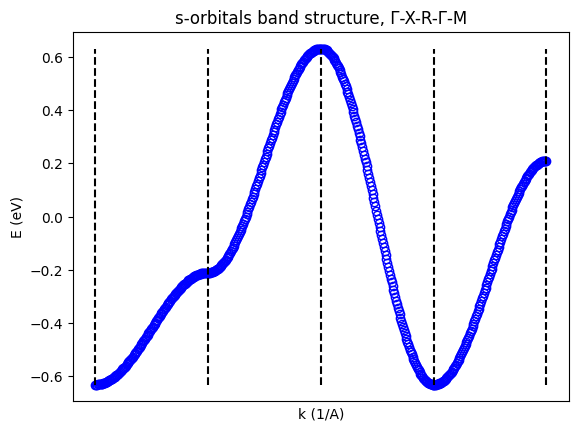

In [47]:
def e_k(x,y,z,a,t):
    return - 2 * t * (np.cos(x * a) + np.cos(y * a) + np.cos(z * a))

def band_structure_s(
    site_elements,
    t,
    a,
    dEs):
    pi = np.pi
    kx = np.linspace(0,pi/a,site_elements)
    ky = np.linspace(0,pi/a,site_elements)
    kz = np.linspace(0,pi/a,site_elements)
    #kxx, kyy = np.meshgrid(kx, ky)

    ek_cos = np.zeros(4*site_elements)
    x = np.linspace(0,4*pi/a,4*site_elements)

    for i in range(site_elements): # from 000 to 00k | Gamma to X
        ek_cos[i] = dEs + e_k(0,0,kz[i],a,t)

    for i in range(site_elements): # from 00k to kkk | Gamma to M
        ek_cos[i + site_elements] = dEs + e_k(kx[i],ky[i],pi/a,a,t)

    for i in range(site_elements): # from kkk to 000 | Gamma to M
        ek_cos[i + site_elements*2] = dEs + e_k(pi/a-kx[i],pi/a-ky[i],pi/a-kz[i],a,t)

    for i in range(site_elements): # from 000 to kk0 | Gamma to M
        ek_cos[i + site_elements*3] = dEs + e_k(kx[i],ky[i],0,a,t)

    # scale the ek_cos so it will start at 0
    f = lambda x: x - delta
    delta = np.amin(ek_cos)
    #ek_cos = np.array(list(map(f, ek_cos)))

    # plot dispersion
    plt.plot(x, ek_cos,'o', mfc = 'none', mec = 'blue', color="blue")
    plt.xlabel("k (1/A)")
    plt.ylabel("E (eV)")
    plt.vlines(0, np.amin(ek_cos), np.amax(ek_cos), colors="black", linestyles="--")
    plt.vlines(pi/a, np.amin(ek_cos), np.amax(ek_cos), colors="black", linestyles="--")
    plt.vlines(2*pi/a, np.amin(ek_cos), np.amax(ek_cos), colors="black", linestyles="--")
    plt.vlines(3*pi/a, np.amin(ek_cos), np.amax(ek_cos), colors="black", linestyles="--")
    plt.vlines(4*pi/a, np.amin(ek_cos), np.amax(ek_cos), colors="black", linestyles="--")
    plt.annotate('xyz',xy=(1.1,-1.1),xytext=(1.3,-3.8),               #Adds another annotation for the text that you want
            annotation_clip=True)
    plt.annotate('Maximum Range', xy=(5,5), ha='center', va='center', color='red')
    plt.annotate('Local Max', xy =(3.3, 1), 
                xytext =(3, 1.8),  
                arrowprops = dict(facecolor ='green', 
                                  shrink = 0.05),) 
    #plt.legend()
    #ax1 = plt.gca()
    #ax2 = ax1.twiny()

    #ax2.set_xticks([1, 2, 3, 4, 5, 6])
    #ax1.set_xticks([0,1, 2, 3, 4, 5, 6])
    #ax1.set_xlabel("X-axis 1")
    #ax2.set_xlabel("X-axis 2")
    plt.xticks([])
    plt.title("s-orbitals band structure, Γ-X-R-Γ-M")
    plt.show()
band_structure_s(site_elements, t, a, 0)